In [ ]:
# !pip install -U albumentations

In [ ]:
# !pip install opencv-python

# EDA (Exploratory Data Analysis)

1. [x] augmentation 했을 때 사람이 봐도 구별할 수 있는건지?
2. [ ] 휴리스틱하게 이게 의미있는 이미지인지 직접 구별
3. [ ] 아웃라이어 확인
4. [x]  이미지 확인
5. [x] Category별 밝기 확인
6. [x] Category별 이미지 크기 확인

### 0. Setting

In [1]:
import os
import glob
import random
import numpy as np
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageEnhance

import torch
from torch.utils import data
from dataloader import CustomDataset

import albumentations as A


data_dir = '/opt/ml/input/data/train_all'  # train_all(train + val) 이용
categories = ["Battery", "Clothing", "Glass", "Metal", "Paper", "Paperpack", "Plastic", "Plasticbag", "Styrofoam"]
colors = ["dimgray", "lightcoral", "lightskyblue", "royalblue", "burlywood", "darkorange", "darkviolet", "violet", "khaki"]
num_classes = 9

max_height, max_width = (4987, 5007)

### 1. augmentation 했을 때 사람이 봐도 구별할 수 있는건지?

In [2]:
def compare_augmenation(batch_size, ori_images, category_ids, aug_images1, aug_images2, aug_images3, aug_name1, aug_name2, aug_name3):
    nrows = batch_size
    ncols = 4
    category_ids = list(map(int, category_ids))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, batch_size*6))

    for i in range(nrows):
        # Original image
        axes[i][0].imshow(ori_images[i], aspect='auto') # .permute([1,2,0])
        axes[i][0].grid(False)
        axes[i][0].set_title(f"original image - {categories[category_ids[i]]}", fontsize = 15)
        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])
        

        # Augmentational image1
        axes[i][1].imshow(aug_images1[i], aspect='auto')
        axes[i][1].grid(False)
        axes[i][1].set_title(f"{aug_name1}", fontsize = 15)
        axes[i][1].set_xticks([])
        axes[i][1].set_yticks([])
        
        # Augmentational image2
        axes[i][2].imshow(aug_images2[i], aspect='auto')
        axes[i][2].grid(False)
        axes[i][2].set_title(f"{aug_name2}", fontsize = 15)
        axes[i][2].set_xticks([])
        axes[i][2].set_yticks([])
        
        # Augmentational image3
        axes[i][3].imshow(aug_images3[i], aspect='auto')
        axes[i][3].grid(False)
        axes[i][3].set_title(f"{aug_name3}", fontsize = 15)
        axes[i][3].set_xticks([])
        axes[i][3].set_yticks([])


    plt.show()

In [3]:
batch_size=4

transform1 = A.Compose([
    A.CLAHE(p=1)
])

transform2 = A.Compose([
    A.CLAHE(clip_limit=8.0, tile_grid_size=(8, 8), p=1)
])

transform3 = A.Compose([
    A.CLAHE(clip_limit=4.0, tile_grid_size=(16, 16), p=1)
])

In [4]:
# https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
def collate_fn(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    
    return [data, target]

dataset = CustomDataset(mode='train_all', transform=None)
dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, num_workers=1, collate_fn=collate_fn, shuffle=False)

aug_dataset = CustomDataset(mode='train_all', transform=transform1)
aug_dataloader1 = data.DataLoader(dataset=aug_dataset, batch_size=batch_size, num_workers=1, collate_fn=collate_fn, shuffle=False)

aug_dataset = CustomDataset(mode='train_all', transform=transform2)
aug_dataloader2 = data.DataLoader(dataset=aug_dataset, batch_size=batch_size, num_workers=1, collate_fn=collate_fn, shuffle=False)

aug_dataset = CustomDataset(mode='train_all', transform=transform3)
aug_dataloader3 = data.DataLoader(dataset=aug_dataset, batch_size=batch_size, num_workers=1, collate_fn=collate_fn, shuffle=False)

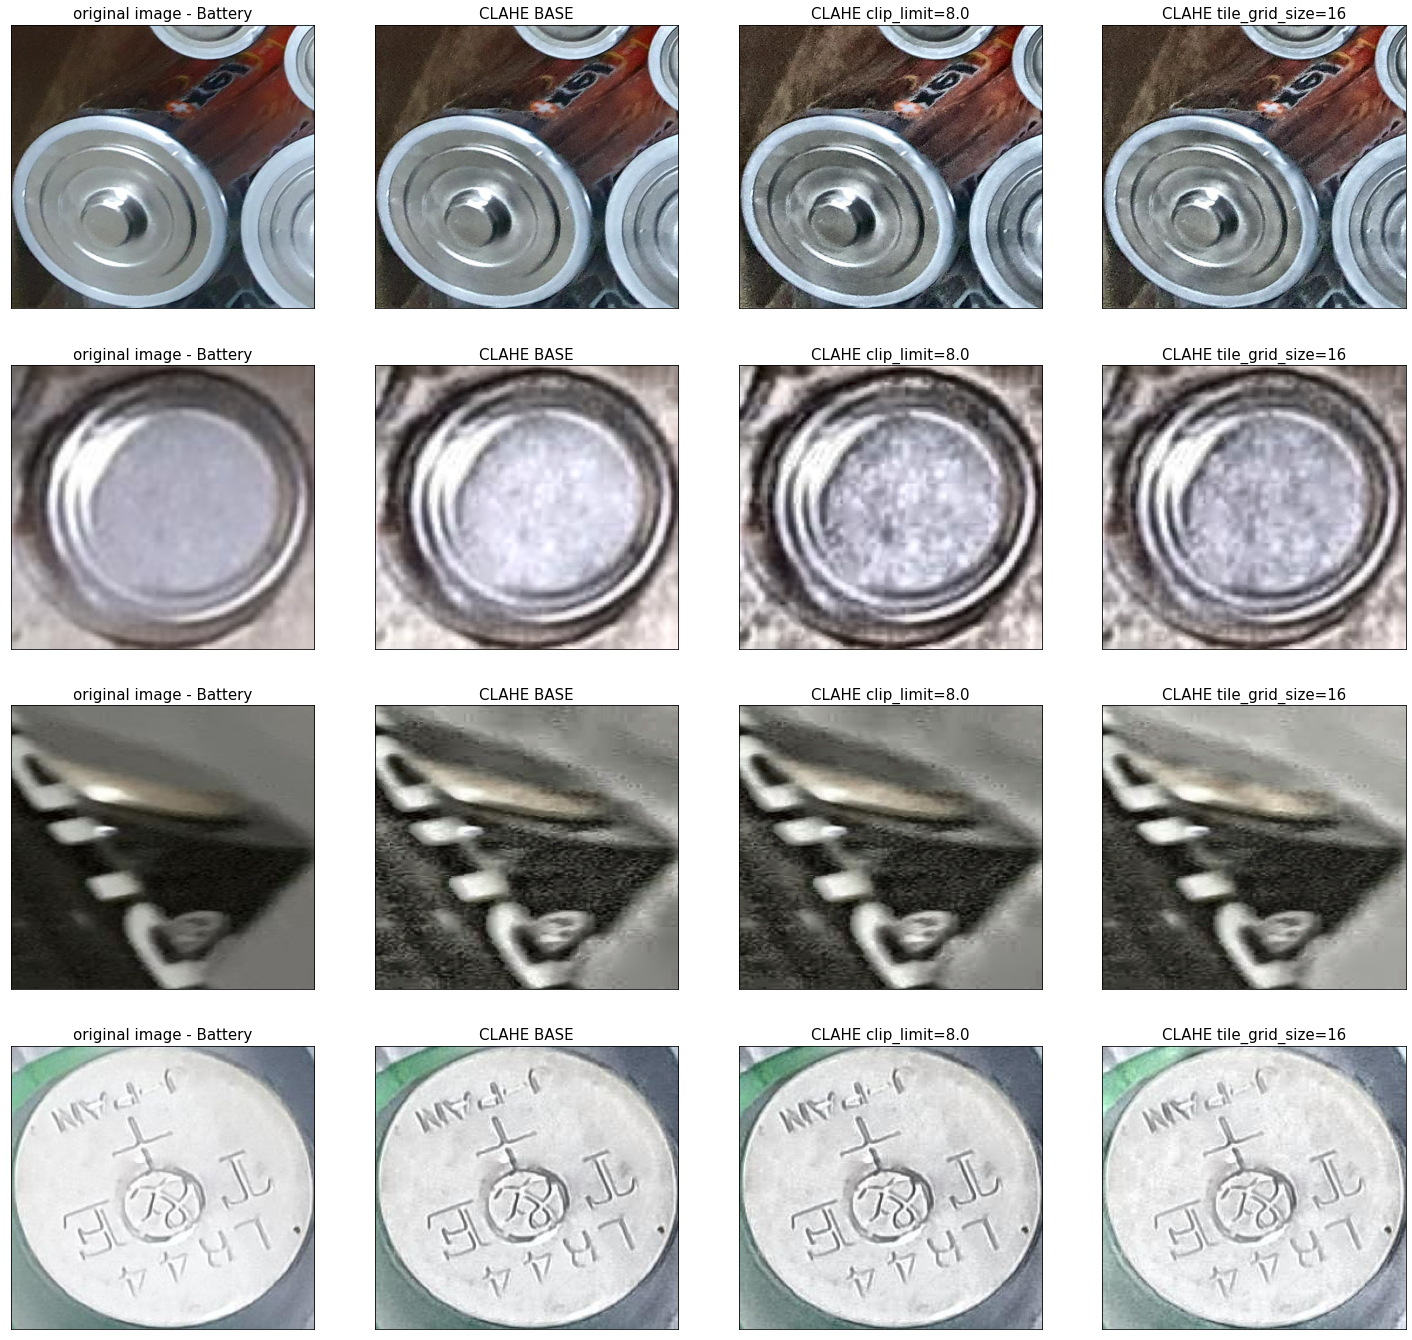

In [5]:
idx = 1
ori_imgs, aug_imgs1, aug_imgs2, aug_imgs3 = None, None, None, None
category_ids = None
for i, datas in enumerate(dataloader):
    if i == idx:
        ori_imgs, category_ids = datas
        break
    
for i, datas in enumerate(aug_dataloader1):
    if i == idx:
        aug_imgs1, _ = datas
        break
    
for i, datas in enumerate(aug_dataloader2):
    if i == idx:
        aug_imgs2, _ = datas
        break
    
for i, datas in enumerate(aug_dataloader3):
    if i == idx:
        aug_imgs3, _ = datas
        break
    
compare_augmenation(batch_size, ori_imgs, category_ids, aug_imgs1, aug_imgs2, aug_imgs3, 'CLAHE BASE', 'CLAHE clip_limit=8.0', 'CLAHE tile_grid_size=16')

### 4. 이미지 확인

In [167]:
img_paths = defaultdict(list)
for category in categories:
    src_dir = os.path.join(data_dir, category)
    img_paths[category] = glob.glob(os.path.join(src_dir, "*"))

def show_sample(category="Battery", max_num=4, keep_ratio=True, want_text=True):
    fig, axes = plt.subplots(max_num//4, 4, figsize=(25, max_num))  # col, row /  W, H
    axes = axes.flatten()
    plt.suptitle(category, fontsize=25)

    img_lists = img_paths[category]
    random.shuffle(img_lists)
    for i, ax in enumerate(axes):
        img = cv2.imread(img_lists[i])  # H, W, C
        height, width = img.shape[:2]
        ax.set_title(img_path.split('/')[-1])
        ax.imshow(img)

        if keep_ratio:
            ax.set_xlim(0, max_width)
            ax.set_ylim(0, max_height)
            
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ['top', 'bottom', 'left', 'right']:
            ax.spines[s].set_visible(False)     # 테두리 제거

        if want_text:
            # height
            x=-350 if keep_ratio else 0
            ax.text(x=x, y=height//2, s=f'{height}',
                fontsize=15,
                fontweight='bold',
                fontfamily='serif',
                color='black',
                linespacing=2,
                va='center', # top, bottom, center
                ha='center', # left, right, center
                rotation='vertical', # vertical?
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8, 
                          ec='lightgray',    # ec: edge color
                          pad=0.3)        # padding
               )

            # width
            y=-350 if keep_ratio else height
            ax.text(x=width//2, y=y, s=f'{width}',
                fontsize=15,
                fontweight='bold',
                fontfamily='serif',
                color='black',
                linespacing=2,
                va='center', # top, bottom, center
                ha='center', # left, right, center
                rotation='horizontal', # vertical?
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8, 
                          ec='lightgray',    # ec: edge color
                          pad=0.3)        # padding
               )

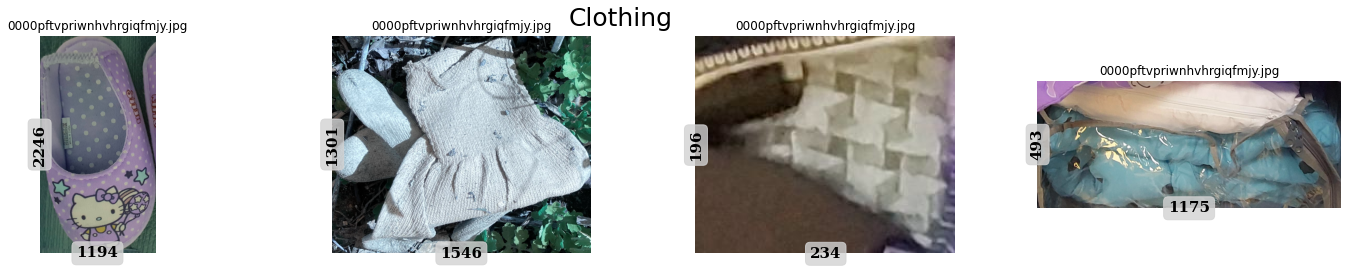

In [170]:
# sample image를 보고싶은 Category, 개수, 비율 유지할지, 이미지 크기 정보 볼지

show_sample(category="Clothing", max_num=4, keep_ratio=False, want_text=True)

### 5. 밝기 확인

**숫자가 낮을 수록 어두운 색**

[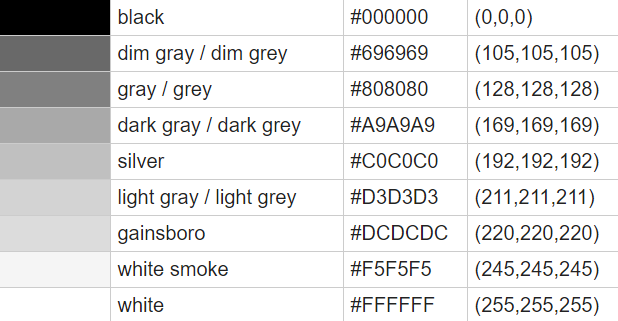](https://www.rapidtables.com/web/color/RGB_Color.html#color-table)

In [11]:
img_medians = defaultdict(list) # outlier에 영향이 적은 중앙값 이용
for category in categories:
    src_dir = os.path.join(data_dir, category)
    for jpgfile in glob.iglob(os.path.join(src_dir, "*")):
        img = cv2.imread(jpgfile)  # H, W, C(BGR)
        img_median = np.median(img)
        img_medians[category].append(img_median)

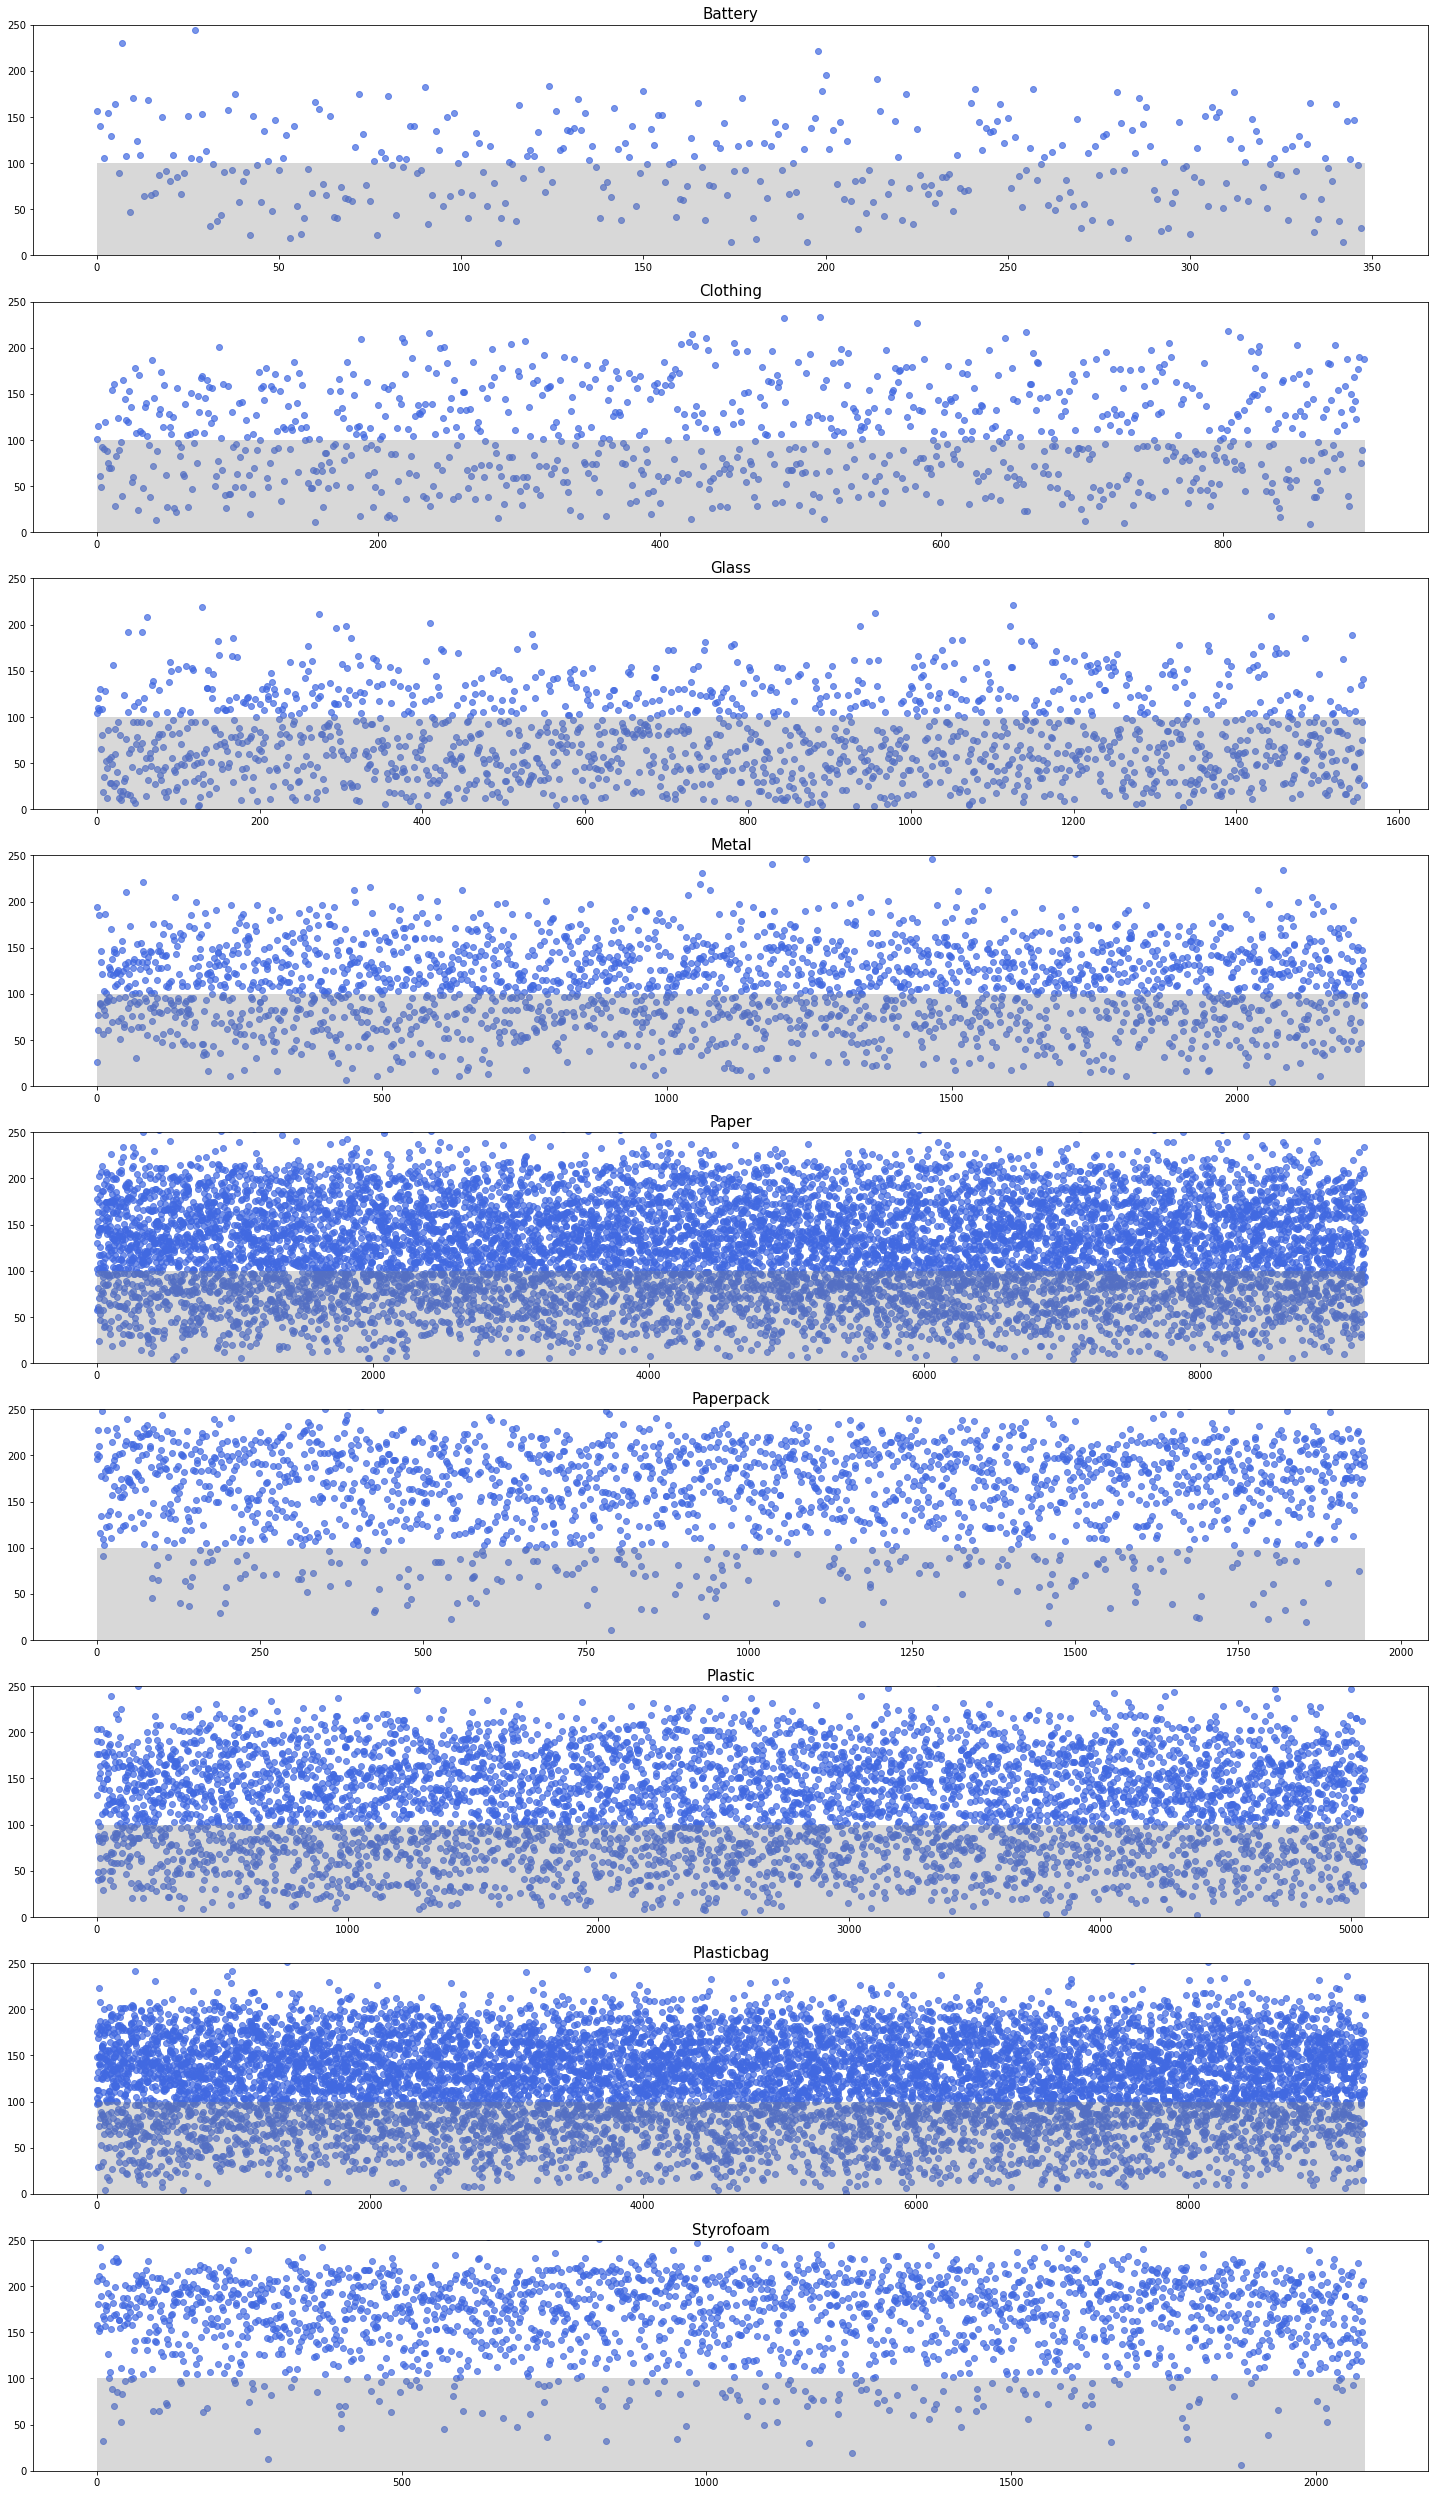

In [14]:
num_classes = 9
fig, axes = plt.subplots(num_classes, 1, figsize=(25, 5*num_classes))  # col, row /  W, H
# plt.suptitle("rgb median", fontsize=20)

axes = axes.flatten()
for i, category in enumerate(categories):
    axes[i].set_title(category, fontsize=15)
    axes[i].scatter(x=range(len(rgb_medians[category])), y=rgb_medians[category], color="royalblue", alpha=0.7)
    axes[i].set_ylim(0, 250)
    
    axes[i].add_patch(
        patches.Rectangle(
            (0, 0), len(rgb_medians[category]), 100,  # left(x) bottom(y), width, height
            facecolor = 'gray',
            alpha = 0.3,
            fill=True
        ))

=> 상대적으로 어두운 이미지가 많아보이는 Glass는 밝게하는(**brightness**) augmentation 을 주면 어떨까?
<br/>Q: **test** time에도?

In [37]:
# i = 102
# sample_path = sample_paths[i]

# sample_path = '/opt/ml/input/data/train/Glass/0000auryqujmbdujziablmyz.jpg'    # 5.0
sample_path = '/opt/ml/input/data/train/Battery/wzeszjobylkczizsnlksvykb.jpg'    # 67.0

sample_img = cv2.imread(sample_path)  # H, W, C(BGR)

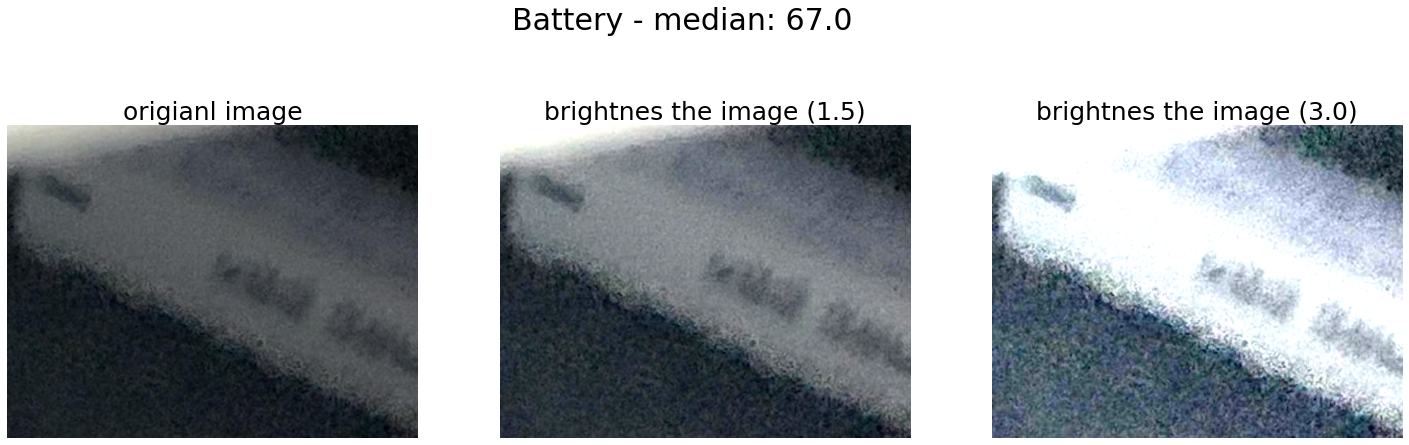

In [38]:
num_classes = 9
fig, axes = plt.subplots(1, 3, figsize=(25, 8))  # col, row /  W, H
category = sample_path.split('/')[6]
title = f'{category} - median: {np.median(sample_img)}'
fig.suptitle(title, fontsize=30)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)     # 테두리 제거
    
#read the image
im = Image.open(sample_path)

#image brightness enhancer
enhancer = ImageEnhance.Brightness(im)

for ax, factor in zip(axes, [1, 1.5, 3.0]):  # 1: gives original image
    im_output = enhancer.enhance(factor)
    ax.imshow(im_output)
    if factor == 1:
        ax.set_title('origianl image', fontsize=25)
    else:
        ax.set_title(f'brightnes the image ({factor})', fontsize=25)

```python
print(sample_img[:,:,2].shape)
print('R')
sample_img[:,:,2]
```

### 6. Category별 이미지 크기 확인

In [40]:
img_shapes = defaultdict(list)
for category in categories:
    src_dir = os.path.join(data_dir, category)
    for jpgfile in glob.iglob(os.path.join(src_dir, "*")):
        img = cv2.imread(jpgfile)  # H, W, C(BGR)
        img_shapes[category].append(img.shape[0:2])  # H, W

In [160]:
# 전체 이미지에 대한 max height, max width

max_height, max_width = 0, 0
for category in categories:
    for img_shape in img_shapes[category]:
        height, width = img_shape
        if height > max_height:
            max_height = height
        if width > max_width:
            max_width = width
            
print(f'max_height: {max_height}, max_width: {max_width}')

max_height: 4987, max_width: 5007


In [161]:
# Category별 max height, max width

for category in categories:
    print(category)
    max_height, max_width = 0, 0
    for img_shape in img_shapes[category]:
        height, width = img_shape
        if height > max_height:
            max_height = height
        if width > max_width:
            max_width = width  
    print(f'max_height: {max_height}, max_width: {max_width}')
    print()

Battery
max_height: 4089, max_width: 2435

Clothing
max_height: 3886, max_width: 3906

Glass
max_height: 4606, max_width: 3217

Metal
max_height: 3789, max_width: 4373

Paper
max_height: 3940, max_width: 4443

Paperpack
max_height: 4081, max_width: 4117

Plastic
max_height: 4987, max_width: 4375

Plasticbag
max_height: 4018, max_width: 5007

Styrofoam
max_height: 4119, max_width: 4031



In [162]:
# Category별 min height, min width

for category in categories:
    print(category)
    min_height, min_width = max_height, max_width
    for img_shape in img_shapes[category]:
        height, width = img_shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width  
    print(f'min_height: {min_height}, min_width: {min_width}')
    print()

Battery
min_height: 75, min_width: 53

Clothing
min_height: 112, min_width: 107

Glass
min_height: 54, min_width: 58

Metal
min_height: 51, min_width: 62

Paper
min_height: 43, min_width: 30

Paperpack
min_height: 63, min_width: 52

Plastic
min_height: 29, min_width: 37

Plasticbag
min_height: 51, min_width: 48

Styrofoam
min_height: 67, min_width: 57



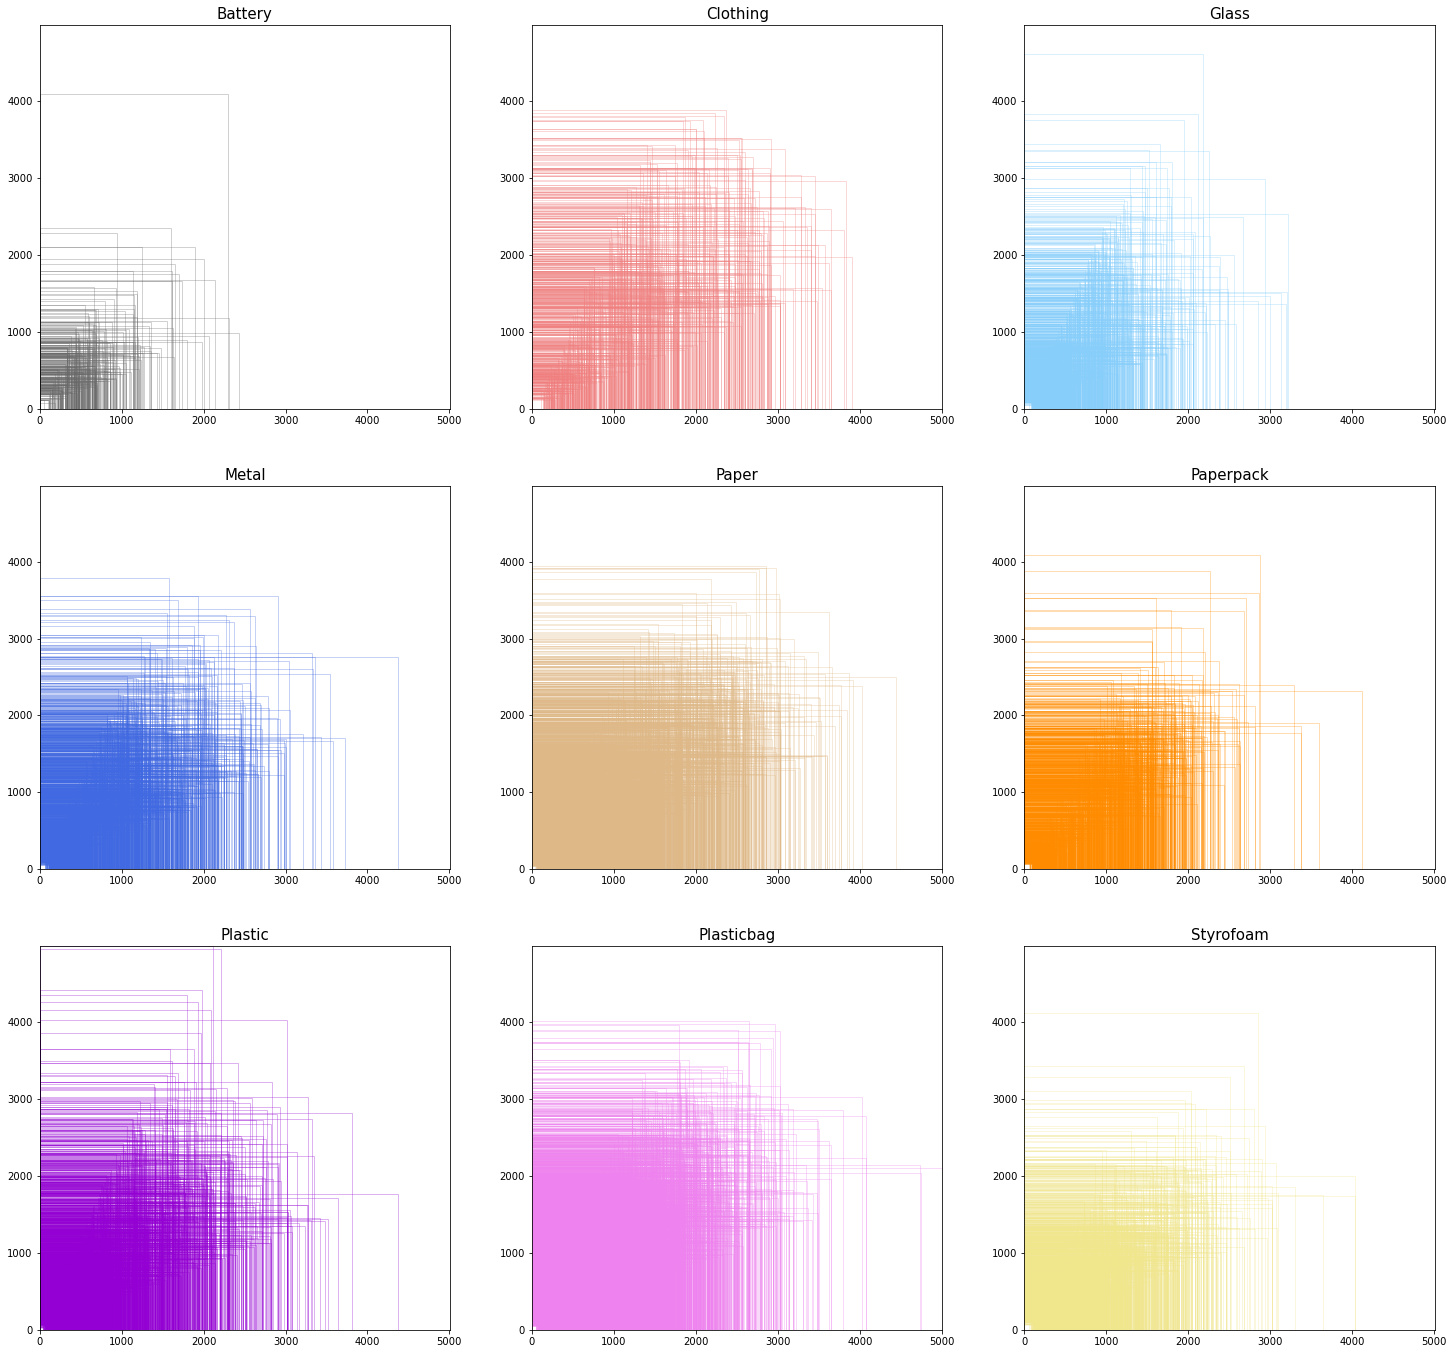

In [127]:
num_classes = 9
fig, axes = plt.subplots(num_classes//3, 3, figsize=(25, 8*num_classes//3))  # col, row /  W, H
# plt.suptitle("image shape", fontsize=20)

axes = axes.flatten()
for i, category in enumerate(categories):
    axes[i].set_title(category, fontsize=15)
    axes[i].set_xlim(0, 5007)
    axes[i].set_ylim(0, 4987)

    for img_shape in img_shapes[category]:
        height, width = img_shape
        axes[i].add_patch(
            patches.Rectangle(
                (0, 0), width, height,  # left(x) bottom(y), width, height
                edgecolor=colors[i],
                # facecolor='gray',
                alpha = 0.3,
                fill=False
            ))